In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from tqdm import tqdm
import librosa

With this file you can directly load a wav file and make classify using our model.

In [2]:
def label_to_num(label):
    if label == 0 :
        return 'gui'
    elif label == 1:
        return "hi"
    elif label == 2:
        return "lau"
    elif label == 3:
        return "sax"
    elif label == 4:
        return "vio"

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.audio_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 32, 3, 1, 1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 32, 3, 1, 1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        
        self.audio_linear = nn.Sequential(nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(32*7*6,128))

        self.gru_hiddend_dim = 128

        self.gru = nn.GRU(128, 128, 1, batch_first=True)

        self.out = nn.Sequential(nn.Linear(128,5)) # 5 classes

    def forward(self,audio_data):


        batch_size = audio_data.size(0)

        x = self.audio_encoder(audio_data.view(-1,1,60,50))

        x = self.audio_linear(x.view(-1,32*7*6))

        h0 = torch.ones(1, batch_size, self.gru_hiddend_dim).to(device)
        
        x, _ = self.gru(x.view((batch_size,-1,128)),h0)# (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        x = x[:,-1,:] # take the last time step for prediction
        
        prediction = self.out(x.reshape(-1,128))
        return x,prediction

In [4]:
device = "cpu"
model = Net()
model.load_state_dict(torch.load("./models/cnn_gru/model5.pth", map_location=lambda storage, loc: storage))
model.eval()

Net(
  (audio_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (audio_linear): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Linear(in_features=1344, out_features=128, bias=True)
  )
  (gru): GRU(128, 128, batch_first=True)
  (out): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

Change the file name below to load a different wav file

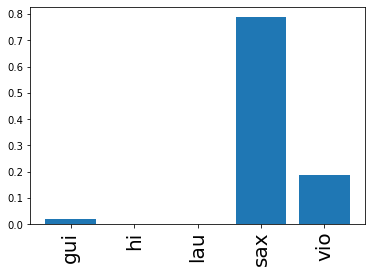

Class probabilities
[0.02102618 0.00091769 0.00158355 0.7882501  0.1882225 ]
Predicted class:sax and confidence: 0.79
sax


In [5]:
label_list =  ['gui','hi','lau','sax','vio']
soft = nn.Softmax(dim=1)

data , sr = librosa.load("./data/FSDKaggle2018.audio_test/008afd93.wav",sr=16000)
hop = sr//25
data = data[:sr*6]
if data.shape[0] != sr*6:
    data = np.resize(data,6*sr)
melspec = librosa.feature.melspectrogram(data, n_mels = 60,hop_length=hop,n_fft=hop*2)
features = librosa.core.amplitude_to_db(melspec)

features = torch.from_numpy(features)
features = features.unfold(1,50,1)
features = features.permute(1,0,2).unsqueeze(0)

_,outputs = model(features.float())

_, preds = torch.max(outputs, 1)
prob = soft(outputs)[0].detach().numpy()
pred_class = preds.item()



plt.xticks(np.arange(5),label_list,rotation=90,fontsize=20)
plt.bar(np.arange(5),prob)
plt.show()



print("Class probabilities")
print(prob)
print("Predicted class:{} and confidence: {:.2f}".format(label_to_num(pred_class),prob[pred_class]))
print(label_to_num(preds.item()))